In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import ipywidgets as widgets
import matplotlib.gridspec as gs
from ipywidgets import interact_manual

In [2]:
def get_scan_window(position,maze,scan_size=20):
    x,y=position
    w,h = maze.shape
  
    pad_x = [max(0,scan_size-x),max(0,x-(w-scan_size))]
    pad_y = [max(0,scan_size-y),max(0,y-(h-scan_size))] 
    #print(pad_x,pad_y)

    x_min = max(x-scan_size,0)
    x_max = min(x+scan_size,w)
    y_min = max(y-scan_size,0)
    y_max = min(y+scan_size,h)
    
    area = maze[x_min:x_max,y_min:y_max]
    area = np.pad(area,(pad_x,pad_y),mode='constant',constant_values=255)
    
    return area

def get_index(r,alpha):
    r_step=np.arange(0,r,1)
    alpha=alpha*np.pi/180
    a = r_step*np.sin(alpha)
    b = r_step*np.cos(alpha)

    a=np.asarray(a,dtype='int32')+r
    b=np.asarray(b,dtype='int32')+r
    #print(r_step.shape)
    #print(a.shape)
    #print(b.shape)
    return a,b

def unroll_image_grayscale(img):
    n,m = img.shape
    if n!=m:
        raise ValueError("Dimensions must be square...")
    
    r=int(n/2)
    flatten=[]
    for alpha in range(0,360,1):
        a,b = get_index(r,alpha)
        layer=[]
        for i in range(r):
         #   print(i)
            layer.append(img[a[i],b[i]])
        flatten.append(layer)
    unrolled=np.array(flatten)
    return unrolled

def get_position(scan):
    distance = []
    for idx in range(scan.shape[0]):
        flank_down = np.where(scan[idx,:]==0)[0]
        try:
            flank_position=flank_down[0]
        except:
            flank_position = -1
        distance.append(flank_position)
    return np.array(distance)
   

def vis_scan(position,distances,maze):
    
    y,x=position
    cv2.circle(maze,(x,y),radius = 1,color = (0,0,255),thickness=-1)
    for angle,dist in enumerate(distances):
        if dist != -1:
            dx,dy = int(dist*np.cos(angle*np.pi/180)),int(dist*np.sin(angle*np.pi/180))
            sx,sy = x+dx,y+dy
            cv2.circle(maze,(sx,sy),radius = 1,color = (int((255-(angle/360)*255)),0,int((angle/360)*255)),thickness=-1)
        



def scan_points(position,distances,maze):
    
    y,x=position
    lidar_scan = []
    for angle,dist in enumerate(distances):
        if dist != -1:
            dx,dy = int(dist*np.cos(angle*np.pi/180)),int(dist*np.sin(angle*np.pi/180))
            sx,sy = x+dx,y+dy
            lidar_scan.append([angle,dist,sx,sy])
        else:
            lidar_scan.append([angle,dist,x,y])
    return np.array(lidar_scan)  


def get_local_minima_v2(scan_dist,scan_range =30,include_max = False):
    oor = np.where(scan_dist==-1)[0]
    if include_max:
        max_dist_idx = np.random.choice(np.where(scan_dist == np.max(scan_dist))[0])
        max_dist = np.max(scan_dist) if np.max(scan_dist)>0 else scan_range
        max_dist = np.array([[max_dist_idx],[max_dist]]) 
    
    if oor.size!=0:

        indecies = np.where((oor[:-1]-oor[1:])!=-1)[0]
        if indecies.size!=0:
            slices=[]
            if (0 in oor) and (359 in oor): 
                #print('around 0')
                slices.append([oor[indecies[0]],oor[indecies[-1]+1]-360])
            else:
                slices.append([oor[0],oor[indecies[0]]])
                slices.append([oor[indecies[-1]+1],oor[-1]])

            for idx in range(indecies.size):

                if idx!=0:
                    slices.append([oor[indecies[idx-1]+1],oor[indecies[idx]]])
            
            slices = np.array(slices)
            
            pos_angles=np.mean(slices,axis=1).astype(np.int16)
        else:
            pos_angles = np.array([np.mean([oor[0],oor[-1]])])
        
        pos_angles = np.vstack((pos_angles,np.full((pos_angles.shape),scan_range)))
            
    else:
        pos_angles = np.array([])
    
    if include_max:
        #print(pos_angles.shape,max_dist.shape)
        if pos_angles.size!=0:
            pos_angles = np.append(pos_angles,max_dist,axis=1)
        else:
            pos_angles = max_dist
        
    return pos_angles

def vis_pos_angles(position,maze,pos_angles,length=15):
    
    y,x=position
    cv2.circle(maze,(x,y),radius = 2,color = (0,0,255),thickness=-1)
    for idx,angle in enumerate(pos_angles):
        dx,dy = int(length*np.cos(angle*np.pi/180)),int(length*np.sin(angle*np.pi/180))
        sx,sy = x+dx,y+dy
        cv2.line(maze,(x,y),(sx,sy),color = (100,200,0),thickness=1)
    

def check_escape(position,maze):
    
    w,h,c=maze.shape
    x,y = position
    
    if (0<=x<=w)and(0<=y<=h):
        escaped=False
    else:
        escaped=True
    return escaped


def scan_standalone(point,maze_show,scan_range):
    scan_size = scan_range

    maze_iteration = np.copy(maze_show)
    maze_iteration_gray=cv2.cvtColor(maze_iteration,cv2.COLOR_BGR2GRAY)

    
    if maze_iteration_gray[point[0],point[1]]!=0:

        window = get_scan_window(position=point,maze = maze_iteration_gray,scan_size=scan_size)
        
        window_scan = unroll_image_grayscale(window)
        
        dist = get_position(window_scan)
        
        lidar = scan_points(point,dist,maze_iteration)
        
        actions=get_local_minima_v2(
            dist,
            scan_range=scan_size,
            include_max=True
        )
        return True,window,window_scan,dist,lidar,actions
    else:
        return False,None,None,None,None,None

def cut_generated_map(generated_map, start, exit):

    # Mark start and exit position in map
    #============================================
    generated_map[start[0], start[1]] = -1
    generated_map[exit[0], exit[1]] = -1

    # Get border of maze and offset for exit point
    #============================================

    borders = []
    exit_offset = 0

    for col in range(0, generated_map.shape[1] + 1, 1):
        if -1 in generated_map[:, col]:
            exit_offset = col
            break

    for col in range(0, generated_map.shape[1] + 1, 1):
        if 0 in generated_map[:, col]:
            borders.append(col)
            break

    for col in range(generated_map.shape[1] - 1, 0, -1):
        if 0 in generated_map[:, col]:
            borders.append(col)
            break

    for row in range(0, generated_map.shape[0] + 1, 1):
        if 0 in generated_map[row, :]:
            borders.append(row)
            break

    for row in range(generated_map.shape[0] - 1, 0, -1):
        if 0 in generated_map[row, :]:
            borders.append(row)
            break

    # Cut map along borders and adjust start/exit
    #============================================        
    map_cut = np.copy(generated_map[borders[2]:borders[3],borders[0]:borders[1]])

    start = [start[0]-borders[2],start[1]-borders[0]]
    exit=[exit[0]-borders[2],exit[1]-borders[0]-(-borders[0]+exit_offset)]
    
    return map_cut,start,exit

## Exploration Run

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[30 30]
Escaped after 1325


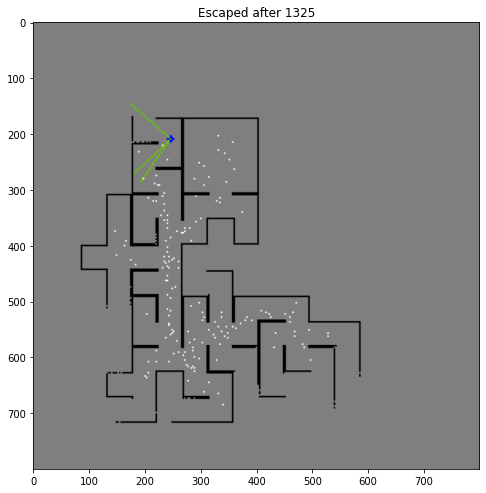

In [73]:
maze_idx = 2

maze_show= cv2.imread(f'03_ROS_Escape_Algorithm/Maze_{maze_idx}.png')
maze_show[maze_show>100]=255
maze_show[maze_show<=100]=0

save=True
final_image = 120

w_init,h_init,c = maze_show.shape
robot_position=np.array([int(w_init/2),int(h_init)/2],dtype=np.int64)
scan_range = 30

image_out = np.zeros((900,1600,3),dtype=np.uint8)

w_video,h_video,c = image_out.shape



record_movement = np.array([[0,0]])

if save:

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(f'maze_exploration_maze_{maze_idx}.mp4', fourcc, 60.0, (h_video,w_video))


maze_map = np.ones((2*scan_range+1,2*scan_range+1))


map_position = np.array([scan_range,scan_range])
map_origin = np.array([scan_range,scan_range])
print(map_position)
init_action = np.array([0,0])

random_actions = np.array([
    [5,0],
    [-5,0],
    [0,5],
    [0,-5],
])

for iteration in range(200000):
    image_out = np.zeros((900,1600,3),dtype=np.uint8)
    
    escaped = check_escape(robot_position,maze_show)
    if not escaped:
        print_iter_out=iteration
    
    w_map,h_map = maze_map.shape
    if iteration==0:
        alpha = 0
        length = 0
        action = init_action
    elif escaped:
        alpha = 0
        length = 0
        action = init_action
    
    elif pos_angles.size!=0:
        #print('Angles',pos_angles)
        a = np.random.choice(np.arange(0,pos_angles.shape[1],1))
        
        alpha = pos_angles[0,a]
        step_length = np.arange(1,pos_angles[1,a],3)
        length =np.random.choice(step_length)
        dx,dy = int(length*np.cos(alpha*np.pi/180)),int(length*np.sin(alpha*np.pi/180))
        action=np.array([dy,dx])
      
    
    elif (maze_show[robot_position[0],robot_position[1]]==0).all():
        print('On Wall')
        pos_angles=np.array([])
        idx = np.random.choice(np.arange(0,random_actions.shape[0],1))
        action = random_actions[idx]
    
    robot_position += action
    map_position += [action[1],action[0]]
    
    if not escaped:
        record_movement = np.append(record_movement,np.copy(action).reshape((1,2)),axis=0) 
    
    
    if (0>(map_position[0]-scan_range))or(w_map<(map_position[0]+scan_range))or (0>(map_position[1]-scan_range))or(h_map<(map_position[1]+scan_range)):
        pad_y = [abs(min(0,action[0])),max(0,action[0])]
        pad_x = [abs(min(0,action[1])),max(0,action[1])]
        #print(pad_x,pad_y)
    else:
        pad_x = [0,0]
        pad_y = [0,0]
        
    map_position += [pad_x[0],pad_y[0]]    
    map_origin += [pad_x[0],pad_y[0]]    
    
    maze_map = np.pad(maze_map,(pad_x,pad_y),mode='constant',constant_values=1)
    
    
    if not escaped:
        On_track,_,_,dist,lidar,pos_angles = scan_standalone(robot_position,maze_show,scan_range=scan_range)
        #print(pos_angles)
        
    
        maze_map[map_position[0],map_position[1]]=2

        try:
            for i in enumerate(dist):

                angle,distance = i
                x,y = map_position
                if distance!=-1:

                    dx,dy = int(distance*np.cos(angle*np.pi/180)),int(distance*np.sin(angle*np.pi/180))
                    #print(distance,y,y+dy,x+dx)
                    maze_map[x+dx,y+dy]=0
                    
        except TypeError:
            print(dist)

    map_show = np.copy(maze_map)*(255/2)
    
    
    w_scale,h_scale = map_show.shape
    pad_show_x,pad_show_y = abs(min(0,w_scale-h_scale)),max(0,w_scale-h_scale) 
    map_show = np.pad(map_show,((0,pad_show_x),(0,pad_show_y)),mode='constant',constant_values=np.uint8(255/2))
    
    
    map_show = cv2.cvtColor(map_show.astype(np.uint8),cv2.COLOR_GRAY2BGR)
    cv2.circle(map_show,(map_position[1],map_position[0]),radius = 2,color = (0,0,255),thickness=-1)
    
    for idx in range(pos_angles.shape[1]):
        ang,d = pos_angles[:,idx]
        dy,dx = int((d-1)*np.cos(ang*np.pi/180)),int((d-1)*np.sin(ang*np.pi/180))
        sx,sy = map_position[1]+dx,map_position[0]+dy
        cv2.line(map_show,(map_position[1],map_position[0]),(sx,sy),color = (100,200,0),thickness=1)

    map_show=cv2.transpose(map_show)

    maze_position = np.copy(maze_show)
    cv2.circle(maze_position,(robot_position[1],robot_position[0]),radius = 3,color = (0,0,255),thickness=-1)
    cv2.circle(maze_position,(robot_position[1],robot_position[0]),radius = scan_range,color = (0,255,0),thickness=1)
    maze_position=cv2.resize(maze_position,(800,800),interpolation = cv2.INTER_AREA)

    image_out[:800,:800,:]=maze_position
    image_out[:800,800:,:]=cv2.resize(map_show,(800,800),interpolation = cv2.INTER_AREA)
    
    cv2.rectangle(image_out,(0,800),(1599,899),color = (0,0,255),thickness=2)
    cv2.putText(
        img = image_out,
        text = f"Iteration: {print_iter_out:7}",
        org = (1350,825),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"Step Parameter:",
        org = (800,825),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"r = {int(length)}",
        org = (800,855),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"alpha = {alpha}",
        org = (800,885),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"Escaped: {escaped}",
        org = (20,825),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"Scan Range: {scan_range}",
        org = (20,855),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    
    cv2.imshow('Overview',image_out)
    
    if save: out.write(image_out)
    if cv2.waitKey(1)==ord('q'):
        break
        
    if escaped:
        final_image-=1
        if final_image==0:
            break

print(f'Escaped after {print_iter_out}')

plt.figure(figsize=(8,9))
plt.title(f'Escaped after {print_iter_out}')
plt.imshow(map_frame)
cv2.destroyAllWindows()
if save: out.release()

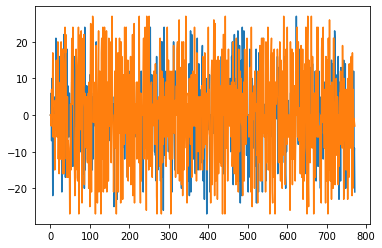

In [58]:
plt.plot(record_movement)

In [59]:

integrate = lambda x: np.array([np.sum(x[:i])for i in range(x.size+1)])

x_movement = integrate(record_movement[:,1])
y_movement = integrate(record_movement[:,0])

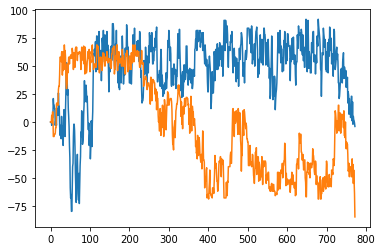

In [60]:
t=np.arange(0,x_movement.size,1)
plt.plot(t,x_movement)
plt.plot(t,y_movement)

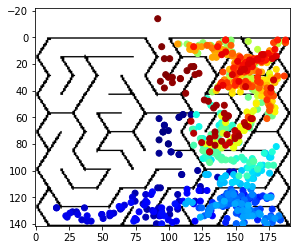

In [72]:
w_maze,h_maze,c = maze_show.shape
#plt.imshow(cv2.transpose(maze_show))
plt.imshow(maze_show)
#plt.scatter(x_movement+w_maze/2,y_movement+h_maze/2,c=np.arange(x_movement.size),cmap='jet')
plt.scatter(
    x_movement+h_maze/2,
    y_movement+w_maze/2,
    c=np.arange(x_movement.size),cmap='jet')

In [500]:
record_movement.shape

(21552, 2)

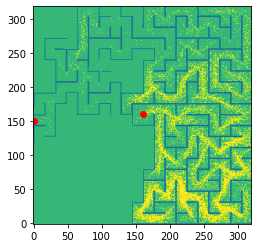

In [512]:
cutting , s,e = cut_generated_map(np.copy(maze_map),map_origin,map_position)



plt.imshow(cutting,origin='lower')
plt.scatter(s[1],s[0],c='r')
#plt.scatter(exit[1]-borders[0],exit[0]-borders[2],c='r')
plt.scatter(e[1],e[0],c='r')


array([265, 211])

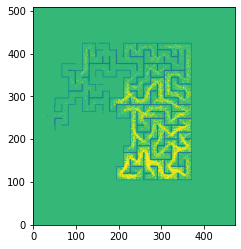

In [501]:
generated_map = np.copy(maze_map)
#generated_map[map_origin[0]-2:map_origin[0]+2,map_origin[1]-2:map_origin[1]+2]=3
#generated_map[map_position[0]-2:map_position[0]+2,map_position[1]-2:map_position[1]+2]=3

generated_map[map_origin[0],map_origin[1]]=-1
generated_map[map_position[0],map_position[1]]=-1
plt.imshow(generated_map,origin='lower')

map_origin

In [502]:
generated_map.shape
borders=[]


for col in range(0,generated_map.shape[1]+1,1):
    if -1 in generated_map[:,col]:
        exit_offset=col
        break       


for col in range(0,generated_map.shape[1]+1,1):
    if 0 in generated_map[:,col]:
        borders.append(col)
        break         

for col in range(generated_map.shape[1]-1,0,-1):
    if 0 in generated_map[:,col]:
        borders.append(col)
        break
        
for row in range(0,generated_map.shape[0]+1,1):
    if 0 in generated_map[row,:]:
        borders.append(row)
        break


for row in range(generated_map.shape[0]-1,0,-1):
    if 0 in generated_map[row,:]:
        borders.append(row)
        break

[50, 370, 105, 424] 33


(50.0, 370.0, 105.0, 424.0)

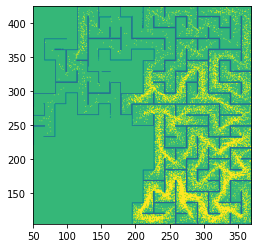

In [503]:
print(borders,exit_offset)
plt.imshow(generated_map,origin='lower')
plt.axis(borders)

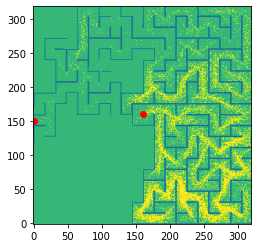

In [504]:
start,exit = map_origin,map_position
map_cut = np.copy(generated_map[borders[2]:borders[3],borders[0]:borders[1]])
plt.imshow(map_cut,origin='lower')
plt.scatter(start[1]-borders[0],start[0]-borders[2],c='r')
#plt.scatter(exit[1]-borders[0],exit[0]-borders[2],c='r')
plt.scatter(exit[1]-borders[0]-(-borders[0]+exit_offset),exit[0]-borders[2],c='r')


start = [start[0]-borders[2],start[1]-borders[0]]
exit=[exit[0]-borders[2],exit[1]-borders[0]-(-borders[0]+exit_offset)]

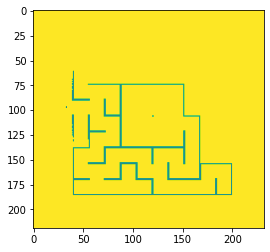

In [462]:
start,exit = map_origin,map_position

empty_map = np.copy(generated_map)
empty_map[empty_map==2]=1
plt.imshow(empty_map)

In [423]:
w_em,h_em = empty_map.shape

px,py = np.meshgrid(np.arange(0,w_em,1),np.arange(0,h_em,1))
Points = np.hstack((px.reshape((w_em*h_em,1)),py.reshape((w_em*h_em,1))))

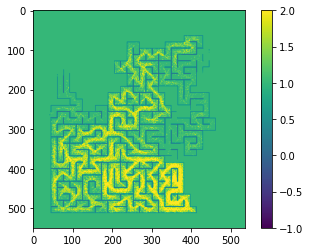

In [424]:
plt.imshow(generated_map)
plt.colorbar()

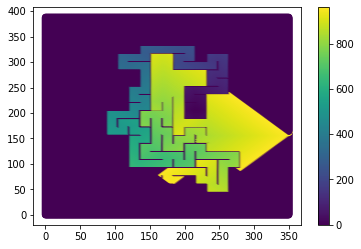

In [346]:

value = [empty_map[point[0],point[1]] for point in Points]
plt.scatter(Points[:,0],Points[:,1],c=value)
plt.colorbar()

Found
Found
4
Exit found
3
Exit found
Found
2
Exit found
1
Exit found
0
Exit found


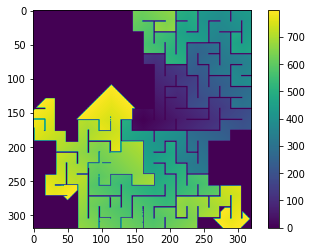

In [506]:
#empty_map = np.copy(generated_map)
empty_map = np.copy(map_cut)
empty_map[empty_map==2]=1
cv_map_boders = np.copy(empty_map)
cv_map_boders[cv_map_boders==-1]=125
cv_map_boders[cv_map_boders==1]=255
cv_map_boders[cv_map_boders==0]=0

#cv_map_boders = ((np.copy(empty_map)-np.min(empty_map))/(np.max(empty_map)-np.min(empty_map)))

cv_map_boders = cv2.cvtColor(np.uint8(cv_map_boders),cv2.COLOR_GRAY2BGR)
cv2.circle(cv_map_boders,(start[1],start[0]),radius = 3,color = (0,0,255),thickness=-1)
cv2.circle(cv_map_boders,(exit[1],exit[0]),radius = 3,color = (0,0,255),thickness=-1)


empty_map[empty_map==2]=1
w_em,h_em = empty_map.shape

grad = [[start[0],start[1]]]

#P = [start[0],start[1]]
#print(grad)
li=grad.copy()
iteration = 1
path_found = False
additional_steps=5
running =True
while running:
    #print(iteration)
    li=grad.copy()
    current_points = len(grad)
    for P in li:
        #print(P)
        
        follow_points=0

        #for i in [-1,0,1]:
        #    for j in [-1,0,1]:
        for i,j in [
            [0,1],
            [1,0],
            [0,-1],
            [-1,0]
        ]:
                if not(i==0 and j==0):
                    if (0<=P[0]+i<w_em) and (0<=P[1]+j<h_em):
                        if ((P[0]+i==exit[0]) and (P[1]+j==exit[1])):

                            print('Found')
                            path_found = True

                        if empty_map[P[0]+i,P[1]+j]==1:
                            follow_points+=0.01
                            grad.append([P[0]+i,P[1]+j])
                            #print('\t',[P[0]+i,P[1]+j])

                   #         empty_map

                  #          print(start[0]+i,start[1]+j)
                            empty_map[P[0]+i,P[1]+j]+=iteration
    
    
    cv_map_show = cv2.applyColorMap(np.uint8(empty_map*255/np.max(empty_map)), cv2.COLORMAP_WINTER)
    cv_map_show = cv2.addWeighted(cv_map_boders,0.7,cv_map_show,0.2,0)
    #print(cv_map_show.shape)
    cv2.imshow('Map',cv_map_show)
    if cv2.waitKey(1)==ord('q'):
        break
    
    if path_found:
        additional_steps -=1
        print(additional_steps)
        print('Exit found')
        if additional_steps==0:
            running=False
        #break
    
    
    for n in range(current_points):
        grad.pop(0)
    iteration+=1
    
    
plt.imshow(empty_map)
plt.colorbar()
cv2.destroyAllWindows()

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       ...,

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

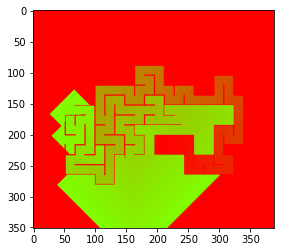

In [370]:
plt.imshow(cv_map_show)
cv_map_show[start[0],start[1]],cv_map_show[exit[0],exit[1]],
cv_map_show

In [507]:
visualize=True
    

running=True
step_back=exit
shortest_path = []
global_distance = []
iteration = 0
while running:
    back = []
    gradient_min=[]
    for i in [-1,0,1]:
                   
        for j in [-1,0,1]:
            if iteration ==0:
                if j==-1:
                    continue

            if [start[0],start[1]]==[step_back[0]+i,step_back[1]+j]:
                print('Finished')
                running=False

            #print(t)

            #vis_cut(empty_map,[step_back[0],step_back[1]],1)
            m = empty_map[step_back[0]+i,step_back[1]+j]
            if m >0:
                back.append([step_back[0]+i,step_back[1]+j])

                global_distance.append(m)
                gradient_min.append(m)

    idx = gradient_min.index(np.min(gradient_min))
    #print(idx)
    step_back = back[idx]
    shortest_path.append(step_back)
    iteration+=1
    if visualize:
        for vis_point in shortest_path:
            cv2.circle(cv_map_show,(vis_point[1],vis_point[0]),radius = 2,color = (0,0,255),thickness=-1)
        
        cv2.imshow('Map',cv_map_show)
        if cv2.waitKey(10)==ord('q'):
            break
            
if visualize: cv2.destroyAllWindows()    

Finished


In [291]:
gradient_min,idx,step_back

([4.0, 3.0, 4.0, 3.0, 2.0, 3.0, 2.0, 2.0], 4, [66, 100])

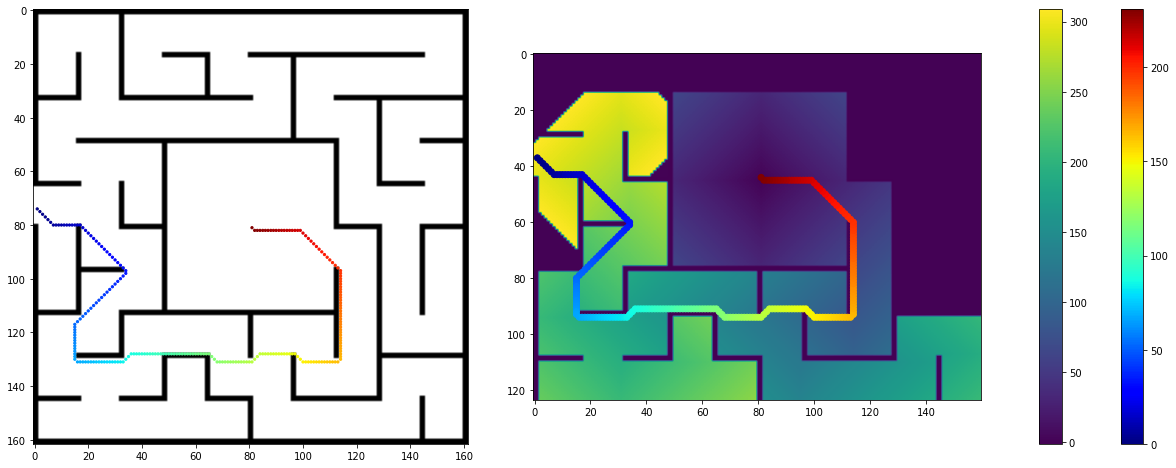

In [493]:
shortest_path = np.array(shortest_path)

w_init,h_init,c = maze_show.shape
grid=gs.GridSpec(1,4,width_ratios=(20,20,1,1),wspace=0.25)

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(grid[0])
bx = fig.add_subplot(grid[1])
cx = fig.add_subplot(grid[2])
dx = fig.add_subplot(grid[3])

ax.imshow(cv2.transpose(maze_show),aspect='equal')
ax.scatter(
    shortest_path[:,1]-shortest_path[-1,1]+w_init/2,
    shortest_path[:,0]-shortest_path[-1,0]+h_init/2,
    c=np.arange(shortest_path.shape[0]),cmap='jet',s=5
)

map_color = bx.imshow(empty_map,aspect='equal')
path_color = bx.scatter(shortest_path[:,1],shortest_path[:,0],c=np.arange(shortest_path.shape[0]),cmap='jet')
fig.colorbar(map_color,cax=cx)
fig.colorbar(path_color,cax=dx)


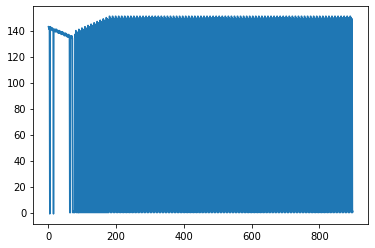

In [256]:
plt.plot(global_distance)

In [282]:
def vis_cut(img,position,size):
    
    area = img[position[0]-size:position[0]+size+1,position[1]-size:position[1]+size+1]
    rows,columns =area.shape
    plt.imshow(area)
    for r in range(rows):
        for c in range(columns):
            plt.text(c,r,f'{area[r,c]}',ha='center',va='center')
    

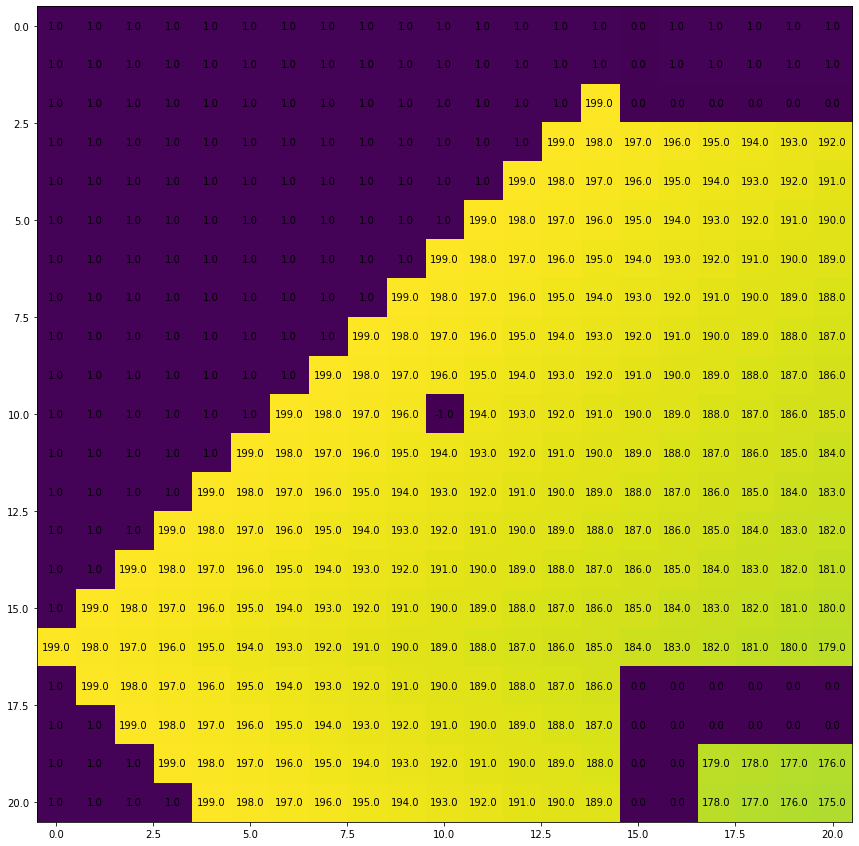

In [283]:
plt.figure(figsize=(15,15))
vis_cut(empty_map,exit,10)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Found
Found
4
Exit found
3
Exit found
Found
2
Exit found
1
Exit found
0
Exit found
Finished


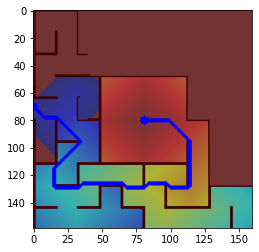

In [74]:
map_cut,start,exit = cut_generated_map(np.copy(maze_map),map_origin,map_position)


#empty_map = np.copy(generated_map)
empty_map = np.copy(map_cut)

empty_map[empty_map==2]=1
cv_map_boders = np.copy(empty_map)
cv_map_boders[cv_map_boders==-1]=125
cv_map_boders[cv_map_boders==1]=255
cv_map_boders[cv_map_boders==0]=0

#cv_map_boders = ((np.copy(empty_map)-np.min(empty_map))/(np.max(empty_map)-np.min(empty_map)))

cv_map_boders = cv2.cvtColor(np.uint8(cv_map_boders),cv2.COLOR_GRAY2BGR)
cv2.circle(cv_map_boders,(start[1],start[0]),radius = 3,color = (0,0,255),thickness=-1)
cv2.circle(cv_map_boders,(exit[1],exit[0]),radius = 3,color = (0,0,255),thickness=-1)


empty_map[empty_map==2]=1
w_em,h_em = empty_map.shape

save=True
if save:
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(f'maze_escape_maze_{maze_idx}.mp4', fourcc, 60.0, (h_em,w_em))



grad = [[start[0],start[1]]]

#P = [start[0],start[1]]
#print(grad)
li=grad.copy()
iteration = 1
path_found = False
additional_steps=5
running =True
while running:
    #print(iteration)
    li=grad.copy()
    current_points = len(grad)
    for P in li:
        #print(P)
        
        follow_points=0

        #for i in [-1,0,1]:
        #    for j in [-1,0,1]:
        for i,j in [
            [0,1],
            [1,0],
            [0,-1],
            [-1,0]
        ]:
                if not(i==0 and j==0):
                    if (0<=P[0]+i<w_em) and (0<=P[1]+j<h_em):
                        if ((P[0]+i==exit[0]) and (P[1]+j==exit[1])):

                            print('Found')
                            path_found = True

                        if empty_map[P[0]+i,P[1]+j]==1:
                            follow_points+=0.01
                            grad.append([P[0]+i,P[1]+j])
                            #print('\t',[P[0]+i,P[1]+j])

                   #         empty_map

                  #          print(start[0]+i,start[1]+j)
                            empty_map[P[0]+i,P[1]+j]+=iteration
    
    
    cv_map_show = cv2.applyColorMap(np.uint8(empty_map*255/np.max(empty_map)), cv2.COLORMAP_JET)
    cv_map_show = cv2.addWeighted(cv_map_boders,0.2,cv_map_show,0.5,0)
    cv2.circle(cv_map_show,(start[1],start[0]),radius = 3,color = (0,0,255),thickness=-1)
    cv2.circle(cv_map_show,(exit[1],exit[0]),radius = 3,color = (0,0,255),thickness=-1)
    #print(cv_map_show.shape)
    cv2.imshow('Map',cv_map_show)
    if save: out.write(cv_map_show)
    if cv2.waitKey(10)==ord('q'):
        break
    
    if path_found:
        additional_steps -=1
        print(additional_steps)
        print('Exit found')
        if additional_steps==0:
            running=False
        #break
    
    
    for n in range(current_points):
        grad.pop(0)
    iteration+=1

 
#break in between
for i in range(120):
    cv2.imshow('Map',cv_map_show)
    if save: out.write(cv_map_show)
    if cv2.waitKey(10)==ord('q'):
        break

visualize=True
    

running=True
step_back=exit
shortest_path = []
global_distance = []
iteration = 0
while running:
    back = []
    gradient_min=[]
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            if iteration ==0:
                if j==-1:
                    continue
                    
            if [start[0],start[1]]==[step_back[0]+i,step_back[1]+j]:
                print('Finished')
                running=False
        
            #print(t)
            
            #vis_cut(empty_map,[step_back[0],step_back[1]],1)
            m = empty_map[step_back[0]+i,step_back[1]+j]
            if m >0:
                back.append([step_back[0]+i,step_back[1]+j])
            
                global_distance.append(m)
                gradient_min.append(m)

    idx = gradient_min.index(np.min(gradient_min))
    #print(idx)
    step_back = back[idx]
    shortest_path.append(step_back)
    iteration+=1
    if visualize:
        for vis_point in shortest_path:
            cv2.circle(cv_map_show,(vis_point[1],vis_point[0]),radius = 1,color = (0,0,255),thickness=-1)
        
        cv2.imshow('Map',cv_map_show)
        if save: out.write(cv_map_show)
        if cv2.waitKey(10)==ord('q'):
            break

            
for i in range(120):
    cv2.imshow('Map',cv_map_show)
    if save: out.write(cv_map_show)
    if cv2.waitKey(10)==ord('q'):
        break            

if save: out.release()
cv2.destroyAllWindows()

plt.imshow(cv_map_show)